In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


         Passengers
Month              
1949-01       112.0
1949-02       118.0
1949-03       132.0
1949-04       129.0
1949-05       121.0


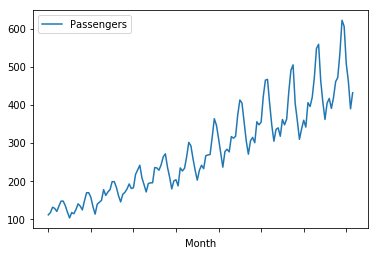

In [2]:
df = pd.read_csv('international-airline-passengers.csv', index_col='Month')
print(df.head())
df.plot()

# Data cleansing

In [3]:
columns_to_keep = ['Passengers']
df = df[columns_to_keep]
df['Passengers'] = df['Passengers'].apply(lambda x: x*1000)
df.index.names = ['Month']
df.sort_index(inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 146


,Passengers
Month,
1949-01,112000.0
1949-02,118000.0
1949-03,132000.0
1949-04,129000.0
1949-05,121000.0


In [4]:
df.describe()

,Passengers
count,144.000000
mean,280298.611111
std,119966.316943
min,104000.000000
25%,180000.000000
50%,265500.000000
75%,360500.000000
max,622000.000000


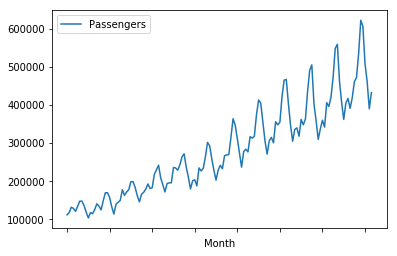

In [5]:
df.plot()

Null values?

In [ ]:
#df.isnull().sum()

In [8]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Passengers    2
dtype: int64

In [ ]:
#print(df[df.isnull().any(axis=1)][null_columns].head())

In [9]:
df.dropna(inplace=True)

In [ ]:
#df.isnull().sum()

In [ ]:
#df.hist(bins=10)

In [ ]:
#len(df[df['Passengers'] == 0])

# Scaled data

In [ ]:
# print('Min', np.min(df))
# print('Max', np.max(df))

We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [10]:
dataset = df.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset) 

In [ ]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

In [ ]:
print(scaled[:10])

# Create the RNN

A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.
Split into train and test sets

In [12]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 100
test: 44


convert an array of values into a dataset matrix

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the energy quantity at a given time (t) and Y is the qty of energy at the next time (t + 1).

In [13]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

reshape into X=t and Y=t+1

In [14]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

100 1
0
X 0 to 1
[0.01544402]
Y 1
0.02702702702702703
1
X 1 to 2
[0.02702703]
Y 2
0.05405405405405403
2
X 2 to 3
[0.05405405]
Y 3
0.04826254826254825
3
X 3 to 4
[0.04826255]
Y 4
0.03281853281853281
4
X 4 to 5
[0.03281853]
Y 5
0.05984555984555981
5
X 5 to 6
[0.05984556]
Y 6
0.08494208494208491
6
X 6 to 7
[0.08494208]
Y 7
0.08494208494208491
7
X 7 to 8
[0.08494208]
Y 8
0.06177606177606179
8
X 8 to 9
[0.06177606]
Y 9
0.028957528957528955
9
X 9 to 10
[0.02895753]
Y 10
0.0
10
X 10 to 11
[0.]
Y 11
0.02702702702702703
11
X 11 to 12
[0.02702703]
Y 12
0.02123552123552122
12
X 12 to 13
[0.02123552]
Y 13
0.04247104247104247
13
X 13 to 14
[0.04247104]
Y 14
0.07142857142857142
14
X 14 to 15
[0.07142857]
Y 15
0.05984555984555981
15
X 15 to 16
[0.05984556]
Y 16
0.04054054054054054
16
X 16 to 17
[0.04054054]
Y 17
0.08687258687258684
17
X 17 to 18
[0.08687259]
Y 18
0.1274131274131274
18
X 18 to 19
[0.12741313]
Y 19
0.1274131274131274
19
X 19 to 20
[0.12741313]
Y 20
0.10424710424710423
20
X 20 to 21
[0.

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].


reshape input to be [samples, time steps, features]

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(98, 1, 1)
(42, 1, 1)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


create and fit the LSTM network

In [16]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 1s - loss: 0.0673
Epoch 2/100
 - 0s - loss: 0.0248
Epoch 3/100
 - 0s - loss: 0.0222
Epoch 4/100
 - 0s - loss: 0.0215
Epoch 5/100
 - 0s - loss: 0.0203
Epoch 6/100
 - 0s - loss: 0.0196
Epoch 7/100
 - 0s - loss: 0.0184
Epoch 8/100
 - 0s - loss: 0.0178
Epoch 9/100
 - 0s - loss: 0.0151
Epoch 10/100
 - 0s - loss: 0.0161
Epoch 11/100
 - 0s - loss: 0.0149
Epoch 12/100
 - 0s - loss: 0.0130
Epoch 13/100
 - 0s - loss: 0.0121
Epoch 14/100
 - 0s - loss: 0.0114
Epoch 15/100
 - 0s - loss: 0.0117
Epoch 16/100
 - 0s - loss: 0.0108
Epoch 17/100
 - 0s - loss: 0.0114
Epoch 18/100
 - 0s - loss: 0.0105
Epoch 19/100
 - 0s - loss: 0.0096
Epoch 20/100
 - 0s - loss: 0.0089
Epoch 21/100
 - 0s - loss: 0.0087
Epoch 22/100
 - 0s - loss: 0.0083
Epoch 23/100
 - 0s - loss: 0.0072
Epoch 24/100
 - 0s - loss: 0.0074
Epoch 25/100
 - 0s - loss: 0.0073
Epoch 26/100
 - 0s - loss: 0.0063
Epoch 27/100
 - 0s - loss: 0.0067
Epoch 28/100
 - 0s - loss: 0.0056
Epoch 29/100
 - 0s - loss: 0.0058
Epoch 30/100
 - 0s - lo

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

Make preditions

In [17]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25730.19 RMSE
Test Score: 92396.24 RMSE


Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.


shift train predictions for plotting

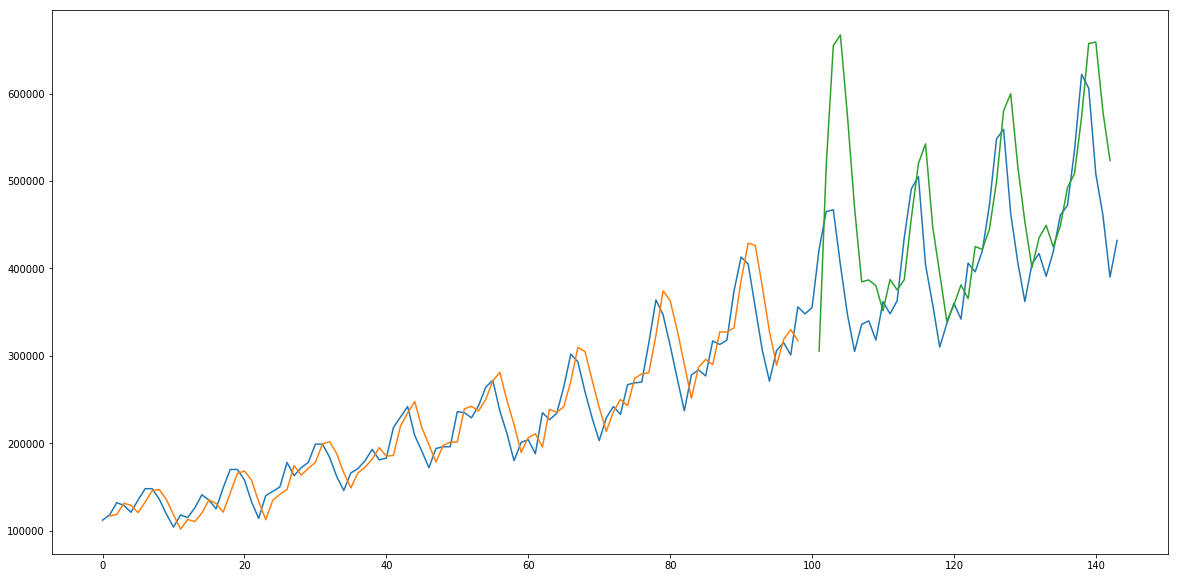

In [18]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()